In [1]:
import cv2
from PIL import Image
import clip
import torch
import numpy as np
import math
import pandas
import plotly.express as px
import datetime
from IPython.core.display import HTML
import matplotlib.pyplot as plt

/home/arty/anaconda3/envs/clip/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_task = './examples/full.mp4'

In [3]:
# all_tasks = [microwave, kettle, light, slide_cabinet, hinge_cabinet, bottom_burner, top_burner]
device = "cuda"
model, preprocess = clip.load("ViT-B/32", device=device)

In [7]:
frames = []
video_cv2 = cv2.VideoCapture(all_task)
frame_cv2 = video_cv2.get(cv2.CAP_PROP_FPS)
current_frame = 0
while video_cv2.isOpened():
    ret, frame = video_cv2.read()
    if ret == True:
        frames.append(Image.fromarray(frame[:, :, ::-1]))
    else:
        break
    current_frame += 1
    video_cv2.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

print(f"Frames extracted: {len(frames)}")

: 

: 

In [ ]:
class Embeddings:
    def __init__(self, task_name, prompt, plot=True, show_frames=False, friend_frames=1):
        self.task_name = task_name
        self.prompt = prompt
        self.plot = plot
        self.show_frames = show_frames
        self.friend_frames = friend_frames
        self.frames = []
        video_cv2 = cv2.VideoCapture(task_name)
        frame_cv2 = video_cv2.get(cv2.CAP_PROP_FPS)
        current_frame = 0
        while video_cv2.isOpened():
            ret, frame = video_cv2.read()
            if ret == True:
                self.frames.append(Image.fromarray(frame[:, :, ::-1]))
            else:
                break
            current_frame += 1
            video_cv2.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

        print(f"Frames extracted: {len(self.frames)}")
        batch_size = 256
        video_batch = math.ceil(len(self.frames) / batch_size)
        image_features = torch.empty([0, 512], dtype=torch.float16).to(device)

        for i in range(video_batch):
            print(f"Processing batch {i+1}/{video_batch}")
            frame_batch = self.frames[i*batch_size : (i+1)*batch_size]
            preprocess_batch = torch.stack([preprocess(frame) for frame in frame_batch]).to(device)
            with torch.no_grad():
                batch_features = model.encode_image(preprocess_batch)
                batch_features /= batch_features.norm(dim=-1, keepdim=True)
            image_features = torch.cat((image_features, batch_features))

        print(f"Features: {image_features.shape}")
        
        with torch.no_grad():
            text_features = model.encode_text(clip.tokenize(prompt).to(device))
            text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T)
        top_frame, index_frame  = similarity.topk(friend_frames, dim=0)
        if plot:
            fig = px.imshow(similarity.T.cpu().numpy(), aspect='auto', color_continuous_scale='viridis')
            fig.update_layout(coloraxis_showscale=False)
            fig.update_xaxes(showticklabels=True)
            fig.update_yaxes(showticklabels=False)
            fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
            fig.show()
            print()
            plt.figure(figsize=(20, 10))
            plt.plot(similarity.cpu().numpy())
        
        if show_frames:
            for i in index_frame:
                display(self.frames[i])
                seconds = round(i.cpu().numpy()[0] * 1 / frame_cv2)
                display(HTML(f"{str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" &t={seconds}\">link</a>)"))
        

In [7]:
Extract = Embeddings(task_name=all_task, prompt="push the kettle", plot=False, show_frames=True, friend_frames=3)

: 

: 

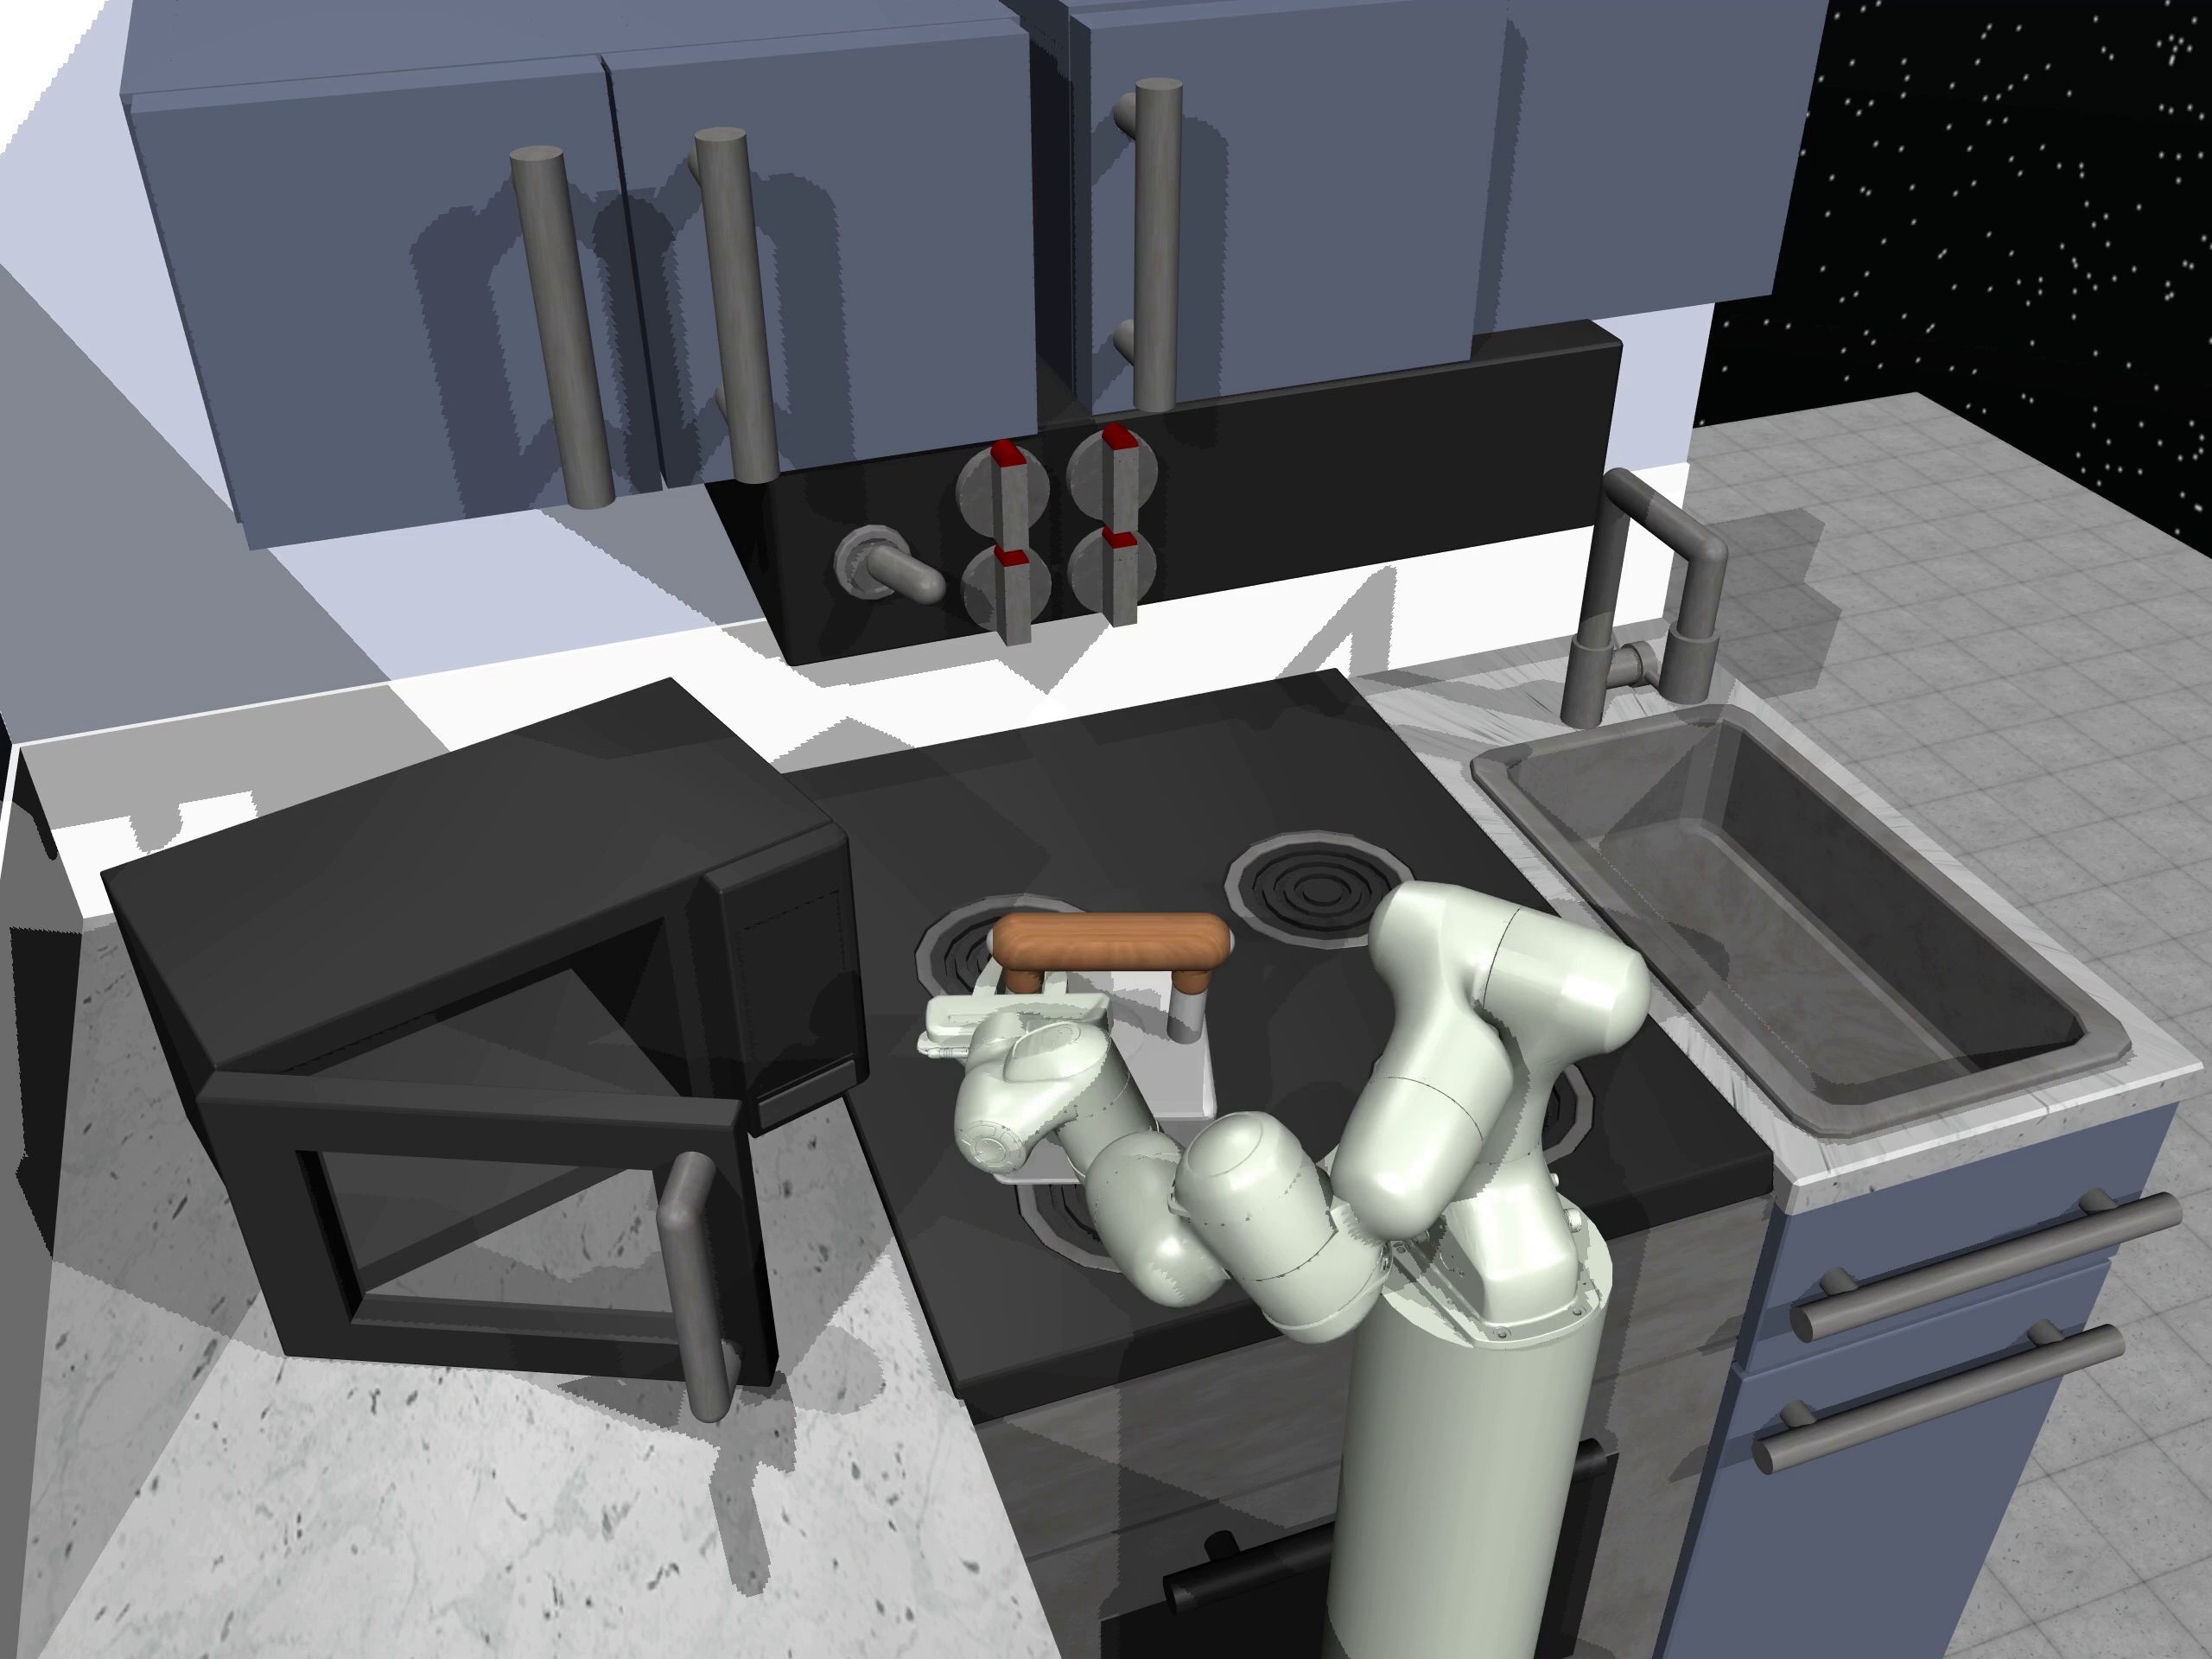

In [24]:
Extract.frames[24]